<b>Contents:</b>

[1  Load data 2014-2016 years](#section_1)

[2  Creating files for cluster analysis](#section_2)

[3  Determining The Optimal Number Of Clusters: Elbow method](#section_3)

[4  Data normalization and cluster creation](#section_4)

[5  Data preprocessing](#section_5)

[6  Finding SARIMA parametrs for clusters](#section_6)

[7  Preprocessing of other clusters](#section_7)

[8  Cluster parametrs](#section_8)

[9  Forecasting](#section_9)

[10  The result](#section_10)



In [27]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from scipy import stats
import glob
from tslearn.clustering import KShape
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

%pylab inline
from sklearn.metrics import r2_score
from pandas.plotting import autocorrelation_plot
from IPython.display import Image
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from itertools import product
from datetime import datetime
import numpy as np
import calendar
from datetime import timedelta
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In this task, I will use the k-Shape algorithm and its implementation in the tslearn library to create clusters.

1. [J. Paparrizos & L. Gravano. k-Shape: Efficient and Accurate Clustering of Time Series](http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf)

2. [tslearn](https://github.com/rtavenar/tslearn)

<a id='section_1'></a>
# Load data 2014-2016 years

In [3]:
trips_2016=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_16_preprocessing/grouped_region_2016_full.csv', index_col='index')
trips_2016.index=pd.to_datetime(trips_2016.index)
trips_2015=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_15_preprocessing/grouped_region_2015_full.csv', index_col='index')
trips_2015.index=pd.to_datetime(trips_2015.index)
trips_2014=pd.read_csv('D:/Asus/Work_DATA/Taxi/Downloads_DATA/data_14_preprocessing/grouped_region_2014_full.csv', index_col='index')
trips_2014.index=pd.to_datetime(trips_2014.index)

In [4]:
trips_2016['2016-01-01':'2016-04-30'].shape

(2904, 102)

<a id='section_2'></a>
# Creating files for cluster analysis

In [5]:
# list of column names - regions numbers
col_list=list(trips_2016.columns)

In [6]:
# creating the nummber of time series for analysis
for col in col_list:
    file_name='data_'+col
    pd.Series(trips_2016[col]['2016-01-01':'2016-04-30'], name='data').to_csv('D:\Asus\Work_DATA\Taxi\C6W4\C6W4_step_2_Kshape\data_frames\\'+file_name +'.csv')
warnings.filterwarnings('ignore')

In [7]:
def read_filedata(filenames):
    ## reading files and output of their structure
    dfs = []
    for filename in filenames:
        original_df = pd.read_csv(filename, index_col=None, header=0)
        dfs.append(original_df)
    return dfs

def time_series_data(dataframes, target_col=None):
    # reading data freims
    tsdata = []
    for i, df in enumerate(dataframes):
        tsdata.append(df[target_col].values.tolist()[:])
        # checking for maximum length
        len_max = 0
        for ts in tsdata:
            if len(ts) > len_max:
                len_max = len(ts)
        # adding data to standardize length if necessary.
        for i, ts in enumerate(tsdata):
            len_add = len_max - len(ts)
            tsdata[i] = ts + [ts[-1]] * len_add
    
    tsdata = np.array(tsdata)
    return tsdata

def transform_vector(time_series_array):
    ## time series vectorizing
    stack_list = []
    for j in range(len(time_series_array)):
        data = np.array(time_series_array[j])
        data = data.reshape((1, len(data))).T
        stack_list.append(data)
    # Converting to a one-dimensional array
    stack_data = np.stack(stack_list, axis=0)
    return stack_data


filenames = sorted(glob.glob('D:\Asus\Work_DATA\Taxi\C6W4\C6W4_step_2_Kshape\data_frames\*.csv'))
df = read_filedata(filenames=filenames)
tsdata = time_series_data(dataframes=df, target_col='data')
stack_data = transform_vector(time_series_array=tsdata)
warnings.filterwarnings('ignore')

Check the order of filenames. This order will be used to create boolean criteria later.

In [8]:
test_names=[x[-8:-4] for x in filenames]
test_names==col_list

True

Ok

<a id='section_3'></a>
# Determining The Optimal Number Of Clusters: Elbow method

Init 1
0.162 --> 0.160 --> 0.155 --> 0.153 --> 0.153 --> 0.153 --> 0.153 --> 0.153 --> 
Init 2
0.172 --> 0.154 --> 0.150 --> 0.149 --> 0.149 --> 0.149 --> 0.149 --> 0.149 --> 
Init 3
0.172 --> 0.147 --> 0.145 --> 0.145 --> 0.145 --> 
Init 4
0.185 --> 0.163 --> 0.156 --> 0.154 --> 0.153 --> 0.153 --> 
Init 5
0.185 --> 0.163 --> 0.156 --> 0.154 --> 0.153 --> 0.153 --> 
Init 6
0.161 --> 0.154 --> 0.154 --> 0.154 --> 
Init 7
0.180 --> 0.155 --> 0.151 --> 0.149 --> 0.149 --> 0.148 --> 0.148 --> 0.148 --> 0.148 --> 
Init 8
0.152 --> 0.149 --> 0.149 --> 
Init 9
0.150 --> 0.149 --> 0.149 --> 
Init 10
0.188 --> 0.180 --> 0.156 --> 0.151 --> 0.151 --> 
Init 1
0.137 --> 0.120 --> 0.109 --> 0.103 --> 0.094 --> 0.094 --> 0.094 --> 
Init 2
0.095 --> 0.093 --> 0.095 --> 
Init 3
0.124 --> 0.109 --> 0.103 --> 0.098 --> 0.095 --> 0.093 --> 0.093 --> 0.094 --> 
Init 4
0.112 --> 0.105 --> 0.104 --> 0.102 --> 0.096 --> 0.091 --> 0.093 --> 
Init 5
0.092 --> 0.093 --> 
Init 6
0.093 --> 0.093 --> 
Init 7
0.08

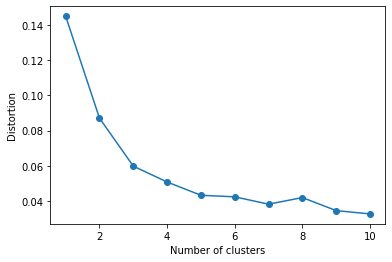

In [29]:
seed = 0
np.random.seed(seed)

# data normalization with TimeSeriesScalerMeanVariance

stack_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(stack_data)

distortions = []

# calculating the number of clusters from 1 to 10
for i  in range(1,11):
    ks = KShape(n_clusters=i, n_init=10, verbose=True, random_state=seed)
    # cluster calculating
    ks.fit(stack_data)
    
    distortions.append(ks.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Calculates the sum of the square distances from each point of the time series to the center of the cluster as the sum of the squares of errors (SSE). 

SSE values are plotted and the number of elbow points is the optimum number of clusters.
https://en.wikipedia.org/wiki/Elbow_method_(clustering)

As we can see on the plot only 3-5 points are looked as elbows so the best number of clusters is no more than 5.


<a id='section_4'></a>
# Data normalization and cluster creation

It is necessary to normalize the data before calculating, this is done by the functionality of the library itself.

Therefore, there is no need to standardize the data.

## Time series analize 

Init 1
Resumed because of empty cluster
Init 1
0.061 --> 0.055 --> 0.055 --> 0.056 --> 
Init 2
Resumed because of empty cluster
Init 2
0.053 --> 0.050 --> 0.051 --> 
Init 3
0.053 --> 0.053 --> 0.054 --> 
Init 4
0.063 --> 0.053 --> 0.053 --> 
Init 5
0.043 --> 0.044 --> 
Init 6
Resumed because of empty cluster
Init 6
0.070 --> 0.067 --> 0.064 --> 0.061 --> 0.060 --> 0.060 --> 0.060 --> 
Init 7
0.052 --> 0.051 --> 0.051 --> 


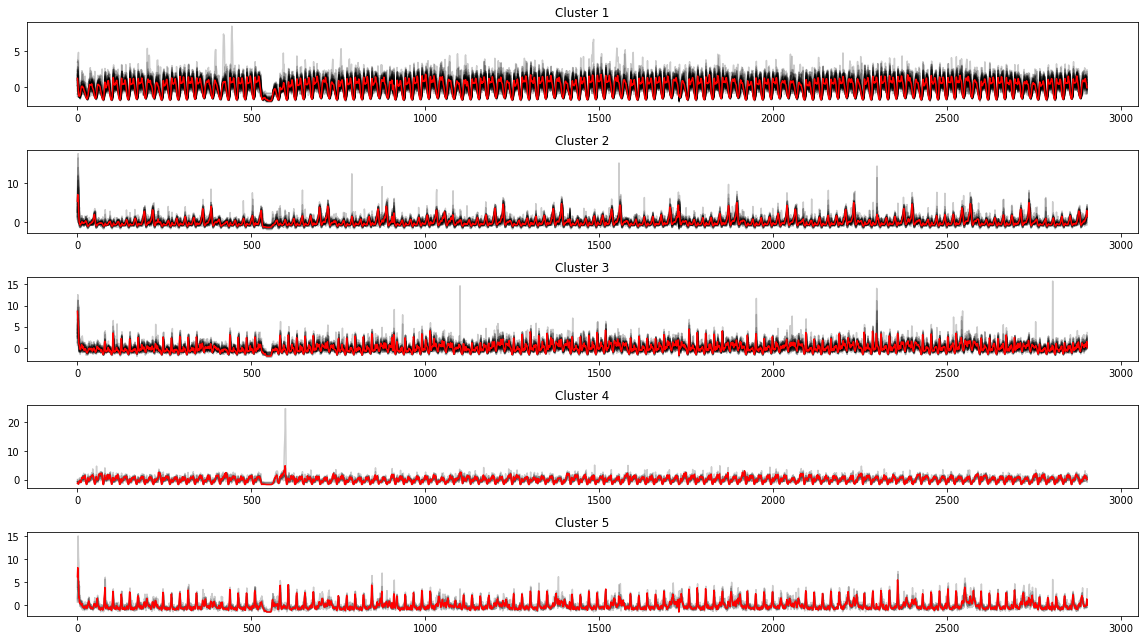

In [10]:
seed = 0
np.random.seed(seed)
# data normalization with TimeSeriesScalerMeanVariance

stack_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(stack_data)

# KShape clustering
ks = KShape(n_clusters=5, n_init=10, verbose=True, random_state=seed)
y_pred = ks.fit_predict(stack_data)

# Clustering and visualization
plt.figure(figsize=(16,9))
for yi in range(5):
    plt.subplot(5,1, 1 + yi)
    for xx in stack_data[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

The red line shows the centers of the clusters.
Their coordinates  are in the *ks.cluster_centers_*

The coordinates of all time series are in *stack_data*.

The predicted cluster numbers are in *y_pred*

## The number and length of clusters

In [12]:

ks.cluster_centers_.shape

(5, 2904, 1)

## The number of time series in each cluster


In [42]:
criteria_0=y_pred==0
print('В 0 кластере содержится '+str(criteria_0.sum()) +' рядов')
criteria_1=y_pred==1
print('В 1 кластере содержится '+str(criteria_1.sum()) +' рядов')
criteria_2=y_pred==2
print('Во 2  кластере содержится '+str(criteria_2.sum()) +' рядов')
criteria_3=y_pred==3
print('В 3 кластере содержится '+str(criteria_3.sum()) +' рядов')
criteria_4=y_pred==4
print('В 4 кластере содержится '+str(criteria_4.sum()) +' рядов')


В 0 кластере содержится 45 рядов
В 1 кластере содержится 26 рядов
Во 2  кластере содержится 20 рядов
В 3 кластере содержится 6 рядов
В 4 кластере содержится 5 рядов


## Selection of the most typical row in the cluster

To find similarity I used Dynamic Time Warping method in tslearn.

More detailed about the method you can read [hear](http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html) and [hear](https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html?highlight=dtw)

In [14]:
def nearest_ts(num_claster):
    # вычисляю расстояния от каждого ряда до центра кластера методом DTW и передаю в список
    vect_list=[]
    for vect in stack_data:
        res=dtw(ks.cluster_centers_[num_claster],vect )
        vect_list.append(res)
    # вычисляю номер ряда наиболее близко расположенного к центру кластера
    col_num=vect_list.index(min(vect_list))
    return col_num

In [37]:
col_mum_0=nearest_ts(0)
col_mum_1=nearest_ts(1)
col_mum_2=nearest_ts(2)
col_mum_3=nearest_ts(3)
col_mum_4=nearest_ts(4)

### Cluster 0

In [38]:
print('В 0 кластере наиболее типичный ряд '+str(col_list[col_mum_0]))

В 0 кластере наиболее типичный ряд 1334


In [53]:
# time series in cluster 0
cluster_list_0=trips_2016.loc[:, criteria_0].columns
cluster_list_0

Index(['1075', '1076', '1077', '1125', '1126', '1127', '1131', '1132', '1179',
       '1180', '1181', '1183', '1184', '1230', '1231', '1232', '1233', '1234',
       '1235', '1279', '1280', '1281', '1282', '1283', '1284', '1285', '1286',
       '1287', '1331', '1332', '1333', '1334', '1335', '1336', '1337', '1338',
       '1382', '1383', '1384', '1385', '1386', '1434', '1684', '1734', '1783'],
      dtype='object')

### Cluster 1

In [54]:
print('В 1 кластере наиболее типичный ряд '+str(col_list[col_mum_1]))

В 1 кластере наиболее типичный ряд 1326


In [55]:
# time series in cluster 1
cluster_list_1=trips_2016.loc[:, criteria_1].columns
cluster_list_1

Index(['1128', '1129', '1130', '1176', '1177', '1178', '1221', '1222', '1223',
       '1227', '1228', '1229', '1272', '1273', '1274', '1278', '1326', '1327',
       '1376', '1377', '1378', '1380', '1426', '1532', '1533', '1630'],
      dtype='object')

### Cluster 2

In [56]:
print('Во 2 кластере наиболее типичный ряд '+str(col_list[col_mum_2]))

Во 2 кластере наиболее типичный ряд 1387


In [57]:
# time series in cluster 2
cluster_list_2=trips_2016.loc[:, criteria_2].columns
cluster_list_2

Index(['1172', '1173', '1174', '1175', '1182', '1224', '1225', '1339', '1387',
       '1388', '1389', '1390', '1431', '1435', '1436', '1437', '1438', '1439',
       '1441', '1442'],
      dtype='object')

### Cluster 3

In [58]:
print('Во 3 кластере наиболее типичный ряд '+str(col_list[col_mum_3]))

Во 3 кластере наиболее типичный ряд 2068


In [59]:
# рtime series in cluster 3
cluster_list_3=trips_2016.loc[:, criteria_3].columns
cluster_list_3

Index(['1733', '2068', '2069', '2118', '2119', '2168'], dtype='object')

### Cluster 4

In [60]:
print('В 4 кластере наиболее типичный ряд '+str(col_list[col_mum_4]))

В 4 кластере наиболее типичный ряд 1530


In [61]:
# time series in cluster 4
cluster_list_4=trips_2016.loc[:, criteria_4].columns
cluster_list_4

Index(['1480', '1482', '1483', '1530', '1580'], dtype='object')

<a id='section_5'></a>
# Data preprocessing

In [28]:
# holydays features prerocessing
# holydays features depending on the days of the week¶
def date_calculate(year):
    date_list=[]
    for y,i,j in zip(usa_holidays['2020'].dt.month.tolist(),usa_holidays['number_of_week'].tolist(), usa_holidays['day_of_week'].tolist()  ):
    
        if calendar.monthcalendar(year,y)[0][j] ==0:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i+1][j])
        else:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i][j])
        date_list.append(res)
    return date_list 
# loading holyday tab from internet
base_url ='https://www.officeholidays.com/countries/usa/2020'
df_list = pd.read_html(base_url, flavor='html5lib')
usa_holidays=df_list[0]


# delete the row as it is the holiday in another state
usa_holidays=usa_holidays.drop([11])
# Add new columns for rolling holidays date transformation
usa_holidays['2020']='2020 '+usa_holidays['Date']
usa_holidays['2020']=pd.to_datetime(usa_holidays['2020']) 
usa_holidays['day_of_week']=0
usa_holidays['number_of_week']=0
#  Leave only rows with dates depending on the days of the week
criteria_1=usa_holidays.Comments.notna()
usa_holidays_1=usa_holidays[criteria_1]
list_of_days=[5,0,0,6,0,6,5,5,5,5,0,0,5,5,3,4,5,5,5]
list_of_weeks_numbers=[0,2,2,1,3,2,0,0,0,0,0,1,0,0,3,3,0,0,0]

usa_holidays.loc[:, 'day_of_week']=list_of_days
usa_holidays.loc[:, 'number_of_week']=list_of_weeks_numbers
usa_holidays['2014']=date_calculate(2014)
usa_holidays['2015']=date_calculate(2015)
usa_holidays['2016']=date_calculate(2016)
# Add the columns with other holidays
usa_holidays['2016_2']='2016 '+usa_holidays['Date']
usa_holidays['2016_2']=pd.to_datetime(usa_holidays['2016_2'])


usa_holidays['2015_2']='2015 '+usa_holidays['Date']
usa_holidays['2015_2']=pd.to_datetime(usa_holidays['2015_2'])


usa_holidays['2014_2']='2014 '+usa_holidays['Date']
usa_holidays['2014_2']=pd.to_datetime(usa_holidays['2014_2'])
# Join dates
usa_holidays['2014'] = np.where(~criteria_1, usa_holidays['2014_2'], usa_holidays['2014'])
usa_holidays['2015'] = np.where(~criteria_1, usa_holidays['2015_2'], usa_holidays['2015'])
usa_holidays['2016'] = np.where(~criteria_1, usa_holidays['2016_2'], usa_holidays['2016'])
#  Delete temporarily used columnsи
usa_holidays=usa_holidays.iloc[:,[8,9,10]]
# Add columns with pre- and day after the holiday
delta=timedelta(days=1)
usa_holidays=usa_holidays['2014'].append(usa_holidays['2015']).append(usa_holidays['2016'])
usa_holidays=usa_holidays.to_frame(name='holidays')
usa_holidays['day_before']=usa_holidays['holidays']-delta
usa_holidays['day_after']=usa_holidays['holidays']+delta
hol_list_hol=usa_holidays.holidays.tolist()
hol_list_before=usa_holidays.day_before.tolist()
hol_list_after=usa_holidays.day_after.tolist()

## load data
def load_data(num_ts):
    grouped_index_16=trips_2016[num_ts]
    grouped_index_15=trips_2015[num_ts]
    grouped_index_14=trips_2014[num_ts]
    grouped_index_14_16=grouped_index_14\
        .append(grouped_index_15)\
        .append(grouped_index_16)
    
    grouped_index_14_16.name='Count'
    
    return grouped_index_14_16

# Check and input missing values

def data_check(series):
    date_rng = pd.date_range(start='2014-01-01', end='2016-06-30 23:00:00', freq='H')
    grouped_index_14_16_add=pd.DataFrame({'Count': 0},index=date_rng )
    series=series.sort_index()
    series=series.to_frame().append(grouped_index_14_16_add)
    grouped=series.groupby(series.index)['Count'].sum().to_frame()
    return grouped

#Find the average values and replace with them data for 2016 for the 
#observed period
def data_storm(series_2):
    list_to_change=((series_2.loc['2015-01-24 05:00:00':'2015-01-26 09:00:00'].Count.values+series_2.loc['2014-01-25 05:00:00':'2014-01-27 09:00:00'].Count.values)/2).astype('int')
    series_2.loc['2016-01-23 05:00:00':'2016-01-25 09:00:00','Count']=list_to_change
    grouped=series_2
    return grouped

# Feature mastering
## Adding holidays
def add_holidays(series_3):
    criteria_hol=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_hol)
    criteria_before=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_before)
    criteria_after=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_after)
    series_3['hol']=np.where(criteria_hol, 1, 0)
    series_3['before_hol']=np.where(criteria_before, 1, 0)
    series_3['after_hol']=np.where(criteria_after, 1, 0)
    grouped=series_3
    return grouped

## Adding intercept, day, week and year's features
def add_features(series_4):
    
    # intercept
    series_4['w_0']=1
    T=len(series_4)
    t=np.linspace(1,T, T)
    # week features
    for j in range(50):
        i=j+1
        name='sw_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/168)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cw_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/168)
        series_4[name]=new_column_values
     # year's features
    for j in range(50):
        i=j+1
        name='sy_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/8766)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cy_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/8766)
        series_4[name]=new_column_values
         # day features
    for j in range(50):
        i=j+1
        name='sh_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/24)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='ch_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/24)
        series_4[name]=new_column_values
    grouped=series_4
    return grouped
    
## selecting the most important features
def feature_selection(series_5, num_features):
    x=series_5.loc[:'2016.04.30 23:00','hol':]
    y=np.array(series_5.loc[:'2016.04.30 23:00','Count']).reshape(-1)
    #apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=num_features)
    fit = bestfeatures.fit(x,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    column_list=featureScores.nlargest(num_features,'Score').Specs.tolist()
    column_list2=['Count'] #, 'hol', 'before_hol', 'after_hol'
    column_list=column_list2+column_list
    column_list=list(set(column_list))
    grouped=series_5[sorted(column_list)]
    return grouped

## splitting data for training and testing sets
def split_data(series_6):
    
    ## intervals till the end of april
    train_sarimax=series_6.loc[:'2016-04-30 23:00']
    x_train_sarimax=train_sarimax.iloc[:,1:]
    y_train_sarimax=train_sarimax.iloc[:,0]
    
    ## intervals till the end of may
    train=series_6.loc[:'2016-06-30 23:00']
    x_train=train.iloc[:,1:]
    y_train=train.iloc[:,0]

    ## test sample
    test=series_6.loc['2016-05-01':]
    return x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax

# Combining all 
def data_preprocessing(num_ts, num_features):
    warnings.filterwarnings('ignore')
    grouped=load_data(num_ts)
    grouped=data_check(grouped)
    grouped= data_storm(grouped)
    grouped=add_holidays(grouped)
    grouped=add_features(grouped)
    grouped=feature_selection(grouped, num_features)
    x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax =split_data(grouped)
    return grouped,  x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax
                              


<a id='section_6'></a>
# Finding SARIMA parametrs for clusters

## Cluster 0

### Training regression

In [98]:
num_ts='1334'
num_features=40
ts_0=data_preprocessing(num_ts, num_features)

In [99]:
train=ts_0[7]
X=np.array(ts_0[5])
Y=np.array(ts_0[6]).reshape(-1)
model = XGBRegressor()
# fit the model
model.fit(X, Y)
preds = model.predict(X)
model.fit(X, Y).score(X, Y)

0.967512405730069

### Regression plot

Text(0, 0.5, 'Trips count')

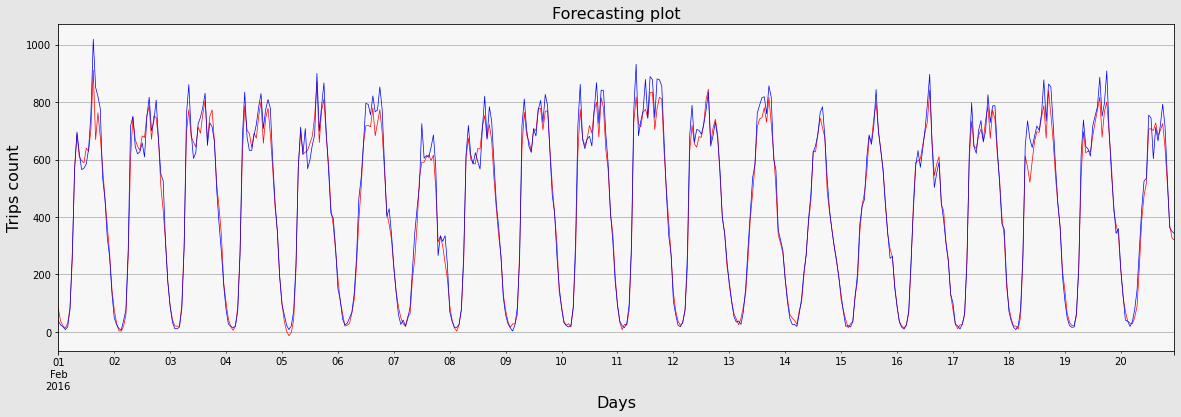

In [100]:
train=train.assign(predict=preds)
train=train.assign(residuals=train.Count-train.predict)
fig, ax = plt.subplots(figsize=(20,6))
fig.set_facecolor('.9')
ax.set_facecolor('.97')
train.loc['2016-02-01' :'2016-02-20']['predict'].plot(color='red', linewidth=0.7, ax=ax)
train.loc['2016-02-01' :'2016-02-20']['Count'].plot(color='blue', linewidth=0.7, ax=ax)
ax.grid(axis='both')
plt.title('Forecasting plot', fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.ylabel('Trips count', fontsize=16)

### Regression residuals differentiation

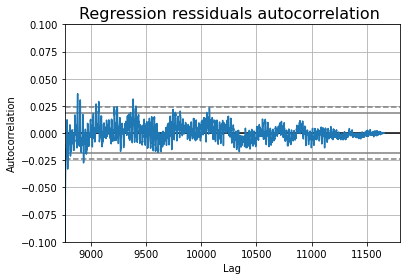

In [103]:
# sesonal differentiation
n=1
# simple differentiation
N=0
nseason=n*8766
train=train.assign(residual_diff=train.residuals - train.residuals.shift(nseason))
train=train.assign(residual_diff2=train.residual_diff - train.residual_diff.shift(N))
autocorrelation_plot(train.residual_diff[nseason+N:])
plt.axis([8766,11800,-0.1,0.1])
plt.title('Regression ressiduals autocorrelation ', fontsize=16)
pyplot.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 720x504 with 0 Axes>

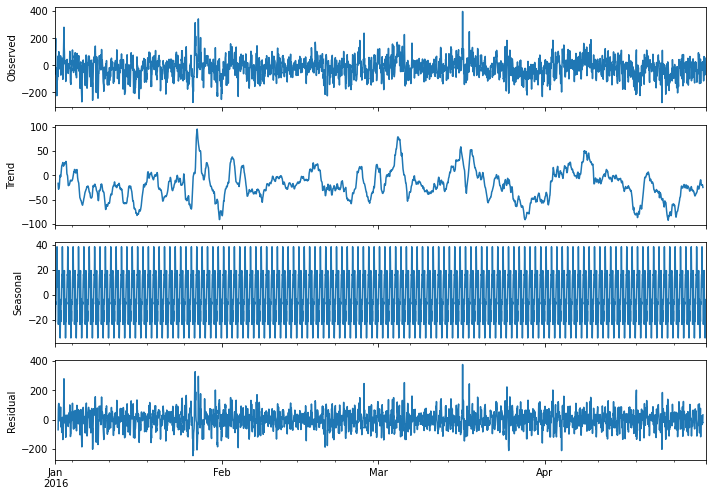

In [105]:
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(train.residual_diff['2016-01-01':]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train.residual_diff['2016-01-01':])[1])

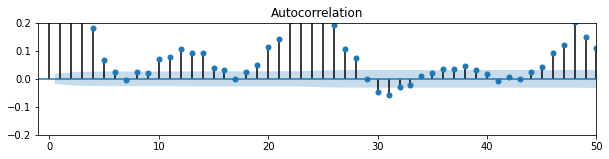

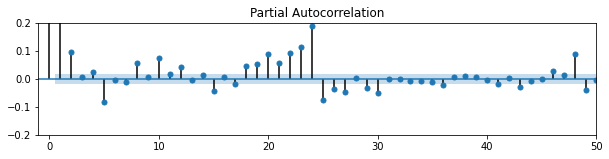

In [106]:
res=sm.tsa.seasonal_decompose(train.residual_diff[nseason:])
res.seasonal.plot()
ax = plt.subplot(312)
sm.graphics.tsa.plot_acf(train.residual_diff[nseason+N:].values.squeeze(), lags=50, ax=ax)
plt.axis([-1,50,-0.2,0.2])
pylab.show()
ax = plt.subplot(313)
sm.graphics.tsa.plot_pacf(train.residual_diff[nseason+N:].values.squeeze(), lags=50, ax=ax)
plt.axis([-1,50,-0.2,0.2])
pylab.show()

### SARIMA parametrs to try

p=2
d=0
q=4

P=4
D=1
Q=4
s=12

<a id='section_7'></a>
# Preprocessing of other clusters

Other 4 clusters were preprocessing in the same way

<a id='section_8'></a>
# Cluster  parametrs

The final parametrs for clusters:
    
    cluster 0 ('2016-01-01',0,1,[1, 0, 1, 0],[2, 0, 2, 0], 12, 40) 
    cluster 1 ('2016-01-01',0,1,[1, 0, 1, 0],[0, 2, 0, 2], 12, 40) 
    cluster 2 ('2016-01-01',0,1,[1, 0, 1, 0],[0, 0, 1, 4], 12, 40) 
    cluster 3 ('2016-01-01',0,1,[0, 0, 1, 4],[0, 0, 0, 3], 12, 40) 
    cluster 4 ('2016-01-01',0,1,[3, 0, 1, 0],[2, 0, 1, 0], 12, 40)

In [108]:
## cluster parametrs (p[0], p[1], p[2], p[3], p[4], p[5], p[6])
    # p[0] - start training date
    # p[1] - simple differentiation
    # p[2] - seasonal differentiation
    # p[3] - parametrs
    # p[4] - extra parametrs, if there was error on the first ones
    # p[5] - seasonality
    # p[6] - the number of features used in forecasting

<a id='section_9'></a>
# Forecasting

Evaluation Metrics:

for May

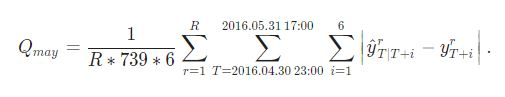

In [7]:
Image(filename='Qmay.JPG', width= 400)

for June

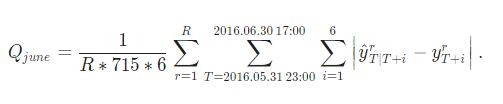

In [8]:
Image(filename='Qjune.JPG', width= 400)

In [31]:
def calculate_ts(ts, period_delta_m, period_delta_y,param_2):
    param_2=param_2
    start_time=param_2[0]
    d=param_2[1]
    D=param_2[2]
    parameters_list = list([param_2[3]])
    reserv_param=param_2[4]
    s=param_2[5]
    num_features=param_2[6]

    cluster_0=data_preprocessing(ts, num_features)
    grouped_0=cluster_0[0]

    ## feature interval till the end of may
    x_train_0=cluster_0[1]

    ## trip's interval till the end of may
    y_train_0=cluster_0[2]

    ## complite dataset till the end of may
    train_0=cluster_0[3]

    ## ---------------------------------

    ## feature interval till the end of april
    x_train_sarimax=cluster_0[5]

    ## trip's interval till the end of april
    y_train_sarimax=cluster_0[6]
    
    ## complite dataset till the end of april
    train_sarimax=cluster_0[7]

    ## --------------------------------------

    ## test sample may-june
    test_data=cluster_0[4]
    train=train_0

    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    train_data=y_train_0[start_time:]
    exog_data=x_train_0[start_time:]

    for param in parameters_list:
        
        try:
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
        
        except ValueError:
            print('wrong parameters:', param)
            param=reserv_param
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
            best_model = model
            continue
        
        except LinAlgError:
            print('singularity parameters:', param)
            param=reserv_param
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
            best_model = model
            continue
        
    
    
        best_model = model
    
    warnings.filterwarnings('default')

    start_predict_time_m=len(train_data[:'2016-04-30 22:00'])
    start_predict_time_j=len(train_data[:'2016-05-31 22:00'])
    period_delta_m=period_delta_m
    period_delta_y=period_delta_y
    res_pred_m=0
    res_pred_j=0
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in range(start_predict_time_m,start_predict_time_m+period_delta_m):
        predicted=best_model.predict(start=t, end=t+5, dynamic=True)
        
        res_pred_m += (np.abs(train_data[t:t+6] - predicted)).sum()/(102*period_delta_m*6)
    ts_Q_may=res_pred_m
    
    for t in range(start_predict_time_j,start_predict_time_j+period_delta_y):
        predicted=best_model.predict(start=t, end=t+5, dynamic=True)
        
        idx=ts+'_'+pd.Index([predicted.index[0].strftime("%Y-%m-%d")]*6)+'_'+str(predicted.index[0].hour)+num_str
        
        series_=pd.Series(predicted.values ,index=idx)
        series=series.append(series_)
        
        res_pred_j += (np.abs(train_data[t:t+6] - predicted)).sum()/(102*period_delta_y*6)
    ts_Q_june=res_pred_j
    return ts_Q_may, ts_Q_june, series

In [62]:
## may score
Q_may=0
## june score
Q_june=0
## the final result, 
## 
answer=pd.Series(dtype='int')

## the number of starting history days in may
period_delta_m=739
## the number of starting history days in june
period_delta_y=715
## boolean criteria for cluster selecting
cluster_list=[cluster_list_0, 
              cluster_list_1, 
              cluster_list_2,
              cluster_list_3,
              cluster_list_4]
## cluster training parametrs
## 
param_list=[('2016-01-01',0,1,[1, 0, 1, 0],[2, 0, 2, 0], 12, 40), 
            ('2016-01-01',0,1,[1, 0, 1, 0],[0, 2, 0, 2], 12, 40), 
            ('2016-01-01',0,1,[1, 0, 1, 0],[0, 0, 1, 4], 12, 40), 
            ('2016-01-01',0,1,[0, 0, 1, 4],[0, 0, 0, 3], 12, 40), 
            ('2016-01-01',0,1,[3, 0, 1, 0],[2, 0, 1, 0], 12, 40)]
n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')

for condition, param in zip(cluster_list, param_list):
    list_columns_cl_2=condition
    param_2=param
    cl_Q_may=0
    cl_Q_june=0
    cl_series=pd.Series(dtype='int')
    for ts in list_columns_cl_2:
        warnings.simplefilter('ignore')
    
        ts_Q_may, ts_Q_june, series =calculate_ts(ts, period_delta_m, period_delta_y,param_2)
        cl_Q_may+=ts_Q_may
        cl_Q_june+=ts_Q_june
        cl_series=cl_series.append(series)
        
        print('Посчитан ряд ',ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
    Q_may+=cl_Q_may
    Q_june+=cl_Q_june
    answer=answer.append(cl_series)
    
    print('Посчитан кластер', n, 'за май и июнь', datetime.now().strftime("%H:%M:%S"))
    n+=1
answer.index.name='id'
answer.name='y'    


print('The end', datetime.now().strftime("%H:%M:%S"))

print(answer.head())

Start: 19:37:19
Посчитан ряд  1075  за май и июнь 19:41:47
Посчитан ряд  1076  за май и июнь 19:46:24
Посчитан ряд  1077  за май и июнь 19:50:42
Посчитан ряд  1125  за май и июнь 19:56:06
Посчитан ряд  1126  за май и июнь 20:03:30
Посчитан ряд  1127  за май и июнь 20:10:55
Посчитан ряд  1131  за май и июнь 20:16:11
Посчитан ряд  1132  за май и июнь 20:22:25
Посчитан ряд  1179  за май и июнь 20:27:09
Посчитан ряд  1180  за май и июнь 20:31:01
Посчитан ряд  1181  за май и июнь 20:36:18
Посчитан ряд  1183  за май и июнь 20:41:38
Посчитан ряд  1184  за май и июнь 20:46:17
Посчитан ряд  1230  за май и июнь 20:50:33
Посчитан ряд  1231  за май и июнь 20:55:11
Посчитан ряд  1232  за май и июнь 21:01:44
Посчитан ряд  1233  за май и июнь 21:07:28
Посчитан ряд  1234  за май и июнь 21:13:16
Посчитан ряд  1235  за май и июнь 21:17:18
Посчитан ряд  1279  за май и июнь 21:21:39
Посчитан ряд  1280  за май и июнь 21:28:22
Посчитан ряд  1281  за май и июнь 21:33:11
Посчитан ряд  1282  за май и июнь 21:3

<a id='section_10'></a>
# The result

In [77]:
print('Ошибка  за май', Q_may)

Ошибка  за май 27.72025433384215


In [67]:
answer.to_csv('submission.csv', sep = ',')

In [69]:
!kaggle competitions submit -c yellowtaxi -f submission.csv -m SARIMAX

Successfully submitted to Жёлтое такси



  0%|          | 0.00/16.1M [00:00<?, ?B/s]
  2%|1         | 272k/16.1M [00:00<00:05, 2.77MB/s]
  9%|9         | 1.45M/16.1M [00:00<00:04, 3.61MB/s]
 12%|#1        | 1.86M/16.1M [00:01<00:15, 972kB/s] 
 18%|#7        | 2.88M/16.1M [00:01<00:10, 1.34MB/s]
 28%|##8       | 4.56M/16.1M [00:01<00:06, 1.85MB/s]
 35%|###5      | 5.68M/16.1M [00:01<00:04, 2.47MB/s]
 41%|####1     | 6.62M/16.1M [00:01<00:03, 3.14MB/s]
 49%|####9     | 7.91M/16.1M [00:01<00:02, 4.08MB/s]
 56%|#####5    | 8.92M/16.1M [00:02<00:01, 4.89MB/s]
 65%|######5   | 10.5M/16.1M [00:02<00:00, 6.15MB/s]
 72%|#######2  | 11.6M/16.1M [00:02<00:00, 6.83MB/s]
 84%|########3 | 13.4M/16.1M [00:02<00:00, 8.47MB/s]
 92%|#########1| 14.7M/16.1M [00:02<00:00, 9.36MB/s]
100%|#########9| 16.0M/16.1M [00:02<00:00, 9.97MB/s]
100%|##########| 16.1M/16.1M [00:04<00:00, 3.57MB/s]
C:\Users\Asus\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:131: ResourceWarning: unclosed file <_io.BufferedWriter name=6>
  return process_handle

June score of SARIMA model: 37.19871

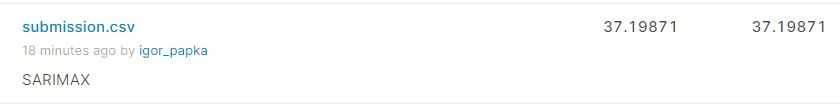

In [78]:
Image(filename='result.JPG', width= 700)